<a href="https://colab.research.google.com/github/ColbertFS/CNN_cancer_de_pulmon/blob/main/Detecci%C3%B3n_de_c%C3%A1ncer_de_pulm%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cargar datos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


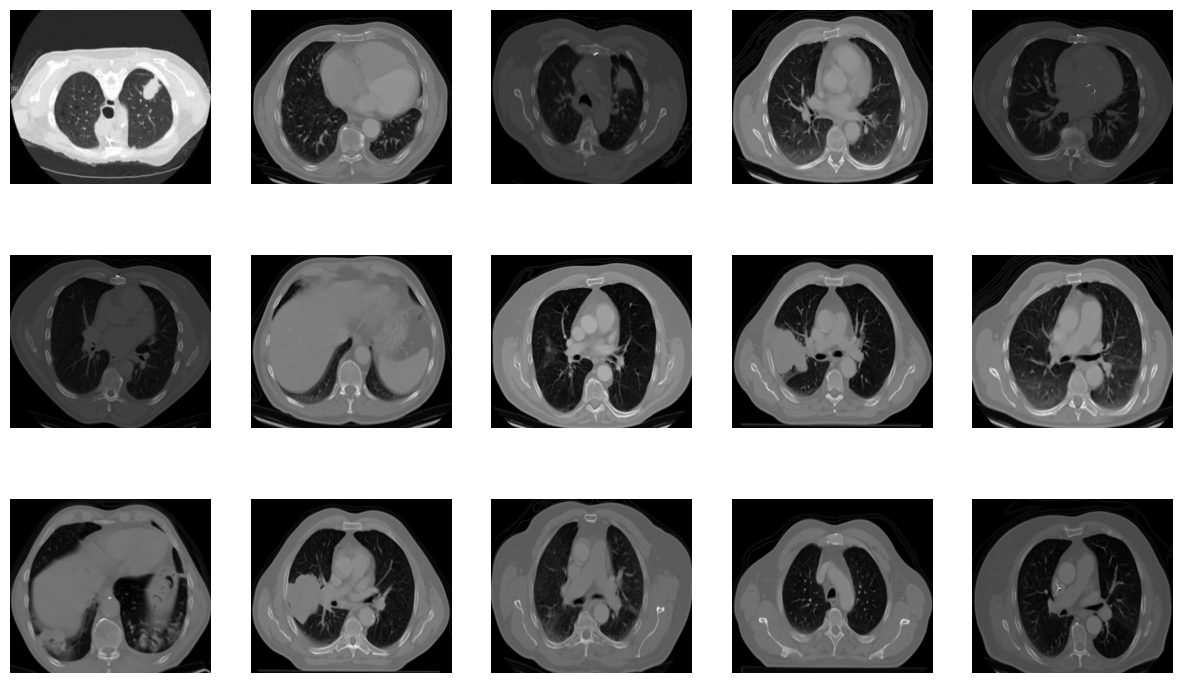

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Path a tu carpeta de imágenes en Drive
path = '/content/drive/MyDrive/Base de datos/Data1/train/Cáncer'

# Lista todos los archivos en ese directorio
archivos = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Mezclar aleatoriamente la lista de archivos
random.shuffle(archivos)

# Si tienes más de 15 imágenes, selecciona solo las primeras 15
archivos = archivos[:15]

# Tamaño deseado para las imágenes redimensionadas
dim = (332, 288)

# Preparar el grid de 3x5 para las imágenes
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

for i, archivo in enumerate(archivos):
    img_path = os.path.join(path, archivo)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Determinar en qué fila y columna debe ir la imagen
    row = i // 5
    col = i % 5

    axs[row, col].imshow(img)
    axs[row, col].axis('off')  # Para ocultar los ejes

plt.show()

**Librerias**

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random

**Lectura de datos y preprocesamiento**

In [ ]:
def preprocesamiento(ruta, img_size):
    #Generador de datos para aumentar el numero de imagenes
    datagen = ImageDataGenerator(
        rotation_range=20,       #Rango para las rotaciones aleatorias
        width_shift_range=0.2,   #Rango para los desplazamientos horizontales aleatorios
        height_shift_range=0.2,  #Rango para los desplazamientos verticales aleatorios
        shear_range=0.2,         #Rango para las transformaciones de corte aleatorias
        zoom_range=0.2,          #Rango para las zoom aleatorios
        horizontal_flip=True,    #Activa la opción de voltear las imágenes horizontalmente
        fill_mode='nearest'      #Estrategia para rellenar los píxeles que pueden quedar fuera de la imagen después de una transformación
    )

    imagenes = []
    for img in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        #Añadir una dimensión extra para los canales de color
        img = np.expand_dims(img, axis=-1)

        #Aumentar la imagen (crear 5 nuevas imágenes a partir de la original)
        it = datagen.flow(img[np.newaxis], batch_size=1)
        for i in range(5):
            batch = it.next()
            imagenes.append(batch[0, :, :, 0])

    return np.array(imagenes)

def preprocesamiento_test(ruta, img_size):
    imagenes = []
    for img in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, img), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        #Añadir una dimensión extra para los canales de color
        img = np.expand_dims(img, axis=-1)
        imagenes.append(img)

    return np.array(imagenes)

**Nota:** La funcion *preprocesamiento_test* tiene la misma tarea que la funcion *preprocesamiento*, con la diferencia que no aumenta los datos, puesto que no es de utilidad y tampoco es recomendable hacerlo con los datos de prueba.

Conjunto de entrenamiento

In [ ]:
#Tamaño de las imagenes
img_size = 112

#Normal
ruta = '/content/drive/MyDrive/Base de datos/Data1/train/Normal'
normal = preprocesamiento(ruta, img_size)
print(normal.shape)

#Cancer
ruta = '/content/drive/MyDrive/Base de datos/Data1/train/Cáncer'
cancer = preprocesamiento(ruta, img_size)
print(cancer.shape)

#Concatenacion
images = np.concatenate([normal, cancer])
images = np.expand_dims(images, axis = -1)    #Agrega una dimensión de canal (1) a las imágenes
print(images.shape)

#Etiquetas
etiqueta_normal = np.repeat(0, normal.shape[0])
etiqueta_cancer = np.repeat(1, cancer.shape[0])

#Clase
class_names = ['Normal', 'Cáncer']
labels = np.concatenate([etiqueta_normal, etiqueta_cancer])

Conjunto de validación

In [ ]:
#Normal
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data1/valid/Normal'
normal_validacion = preprocesamiento(ruta_validacion, img_size)
print(normal_validacion.shape)

#Cancer
ruta_validacion = '/content/drive/MyDrive/Base de datos/Data1/valid/Cáncer'
cancer_validacion = preprocesamiento(ruta_validacion, img_size)
print(cancer_validacion.shape)

#Concatenacion
images_validacion = np.concatenate([normal_validacion, cancer_validacion])
images_validacion = np.expand_dims(images_validacion, axis = -1)
print(images_validacion.shape)

#Etiquetas
etiqueta_normal_validacion = np.repeat(0, normal_validacion.shape[0])
etiqueta_cancer_validacion = np.repeat(1, cancer_validacion.shape[0])

labels_validacion = np.concatenate([etiqueta_normal_validacion, etiqueta_cancer_validacion])


(65, 112, 112)
(295, 112, 112)
(360, 112, 112, 1)


Conjunto de prueba

In [ ]:
#Normal
ruta_test = '/content/drive/MyDrive/Base de datos/Data1/test/Normal'
normal_test = preprocesamiento_test(ruta_test, img_size)
print(normal_test.shape)

#Cancer
ruta_test = '/content/drive/MyDrive/Base de datos/Data1/test/Cáncer'
cancer_test = preprocesamiento_test(ruta_test, img_size)
print(cancer_test.shape)

#Concatenacion
images_test = np.concatenate([normal_test, cancer_test])
#images_test = np.expand_dims(images_test, axis = -1)
print(images_test.shape)

#Etiquetas
etiqueta_normal_test = np.repeat(0, normal_test.shape[0])
etiqueta_cancer_test = np.repeat(1, cancer_test.shape[0])

labels_test = np.concatenate([etiqueta_normal_test, etiqueta_cancer_test])

(54, 112, 112, 1)
(261, 112, 112, 1)
(315, 112, 112, 1)


**Modelo**

In [ ]:
# Modelo de la CNN
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation = "relu", input_shape = [img_size, img_size, 1]))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation = "relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation = "relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(2, activation = "softmax"))

# Propiedades del modelo
taza_de_aprendizaje = 0.001

model.compile(
    #optimizer = keras.optimizers.Adam(learning_rate = taza_de_aprendizaje),
    optimizer = keras.optimizers.SGD(learning_rate = taza_de_aprendizaje),                        #Se puede utilizar como parametros  momentum = 0.5 y nesterov = True para acelerar la convergencia.
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 110, 110, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               49562112  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                      

**Entrenamiento del modelo**

In [ ]:
vueltas = 50

print("Comienza el entrenamiento de la red neuronal...")

start_time = time.time()
historial = model.fit(images, labels, epochs=vueltas, validation_data=(images_validacion, labels_validacion))
end_time = time.time()

print("¡Modelo entrenado!")

#Tiempo de entrenamiento, perdida y precision del modelo:
total_time = end_time - start_time
loss, accuracy = model.evaluate(images_validacion, labels_validacion)
print("\nEl tiempo total de entrenamiento es de {} segundos".format(total_time))
print("\nPérdida: ", loss)
print("\nPrecisión: ", accuracy)


**Curvas de precsición y pérdida**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def color_gradient_plot(y_values, label, cmap, linestyle='-', alpha=1.0, linewidth=1.0):
    x_values = range(1, len(y_values) + 1)
    #Escalamos los valores para que estén en el intervalo [0,1]
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(np.array(y_values).reshape(-1,1)).flatten()
    for i in range(len(y_values)-1):
        color = cmap(scaled_values[i])
        plt.plot(x_values[i:i+2], y_values[i:i+2], color=color, linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    return plt.Line2D([0], [0], color='grey', linestyle=linestyle, alpha=alpha, label=label)

<ipython-input-15-936e719e395e>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  loss_cmap = plt.cm.get_cmap('RdYlGn_r')  # From red to green for losses
<ipython-input-15-936e719e395e>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  acc_cmap = plt.cm.get_cmap('RdYlGn')  # From red to green for accuracy


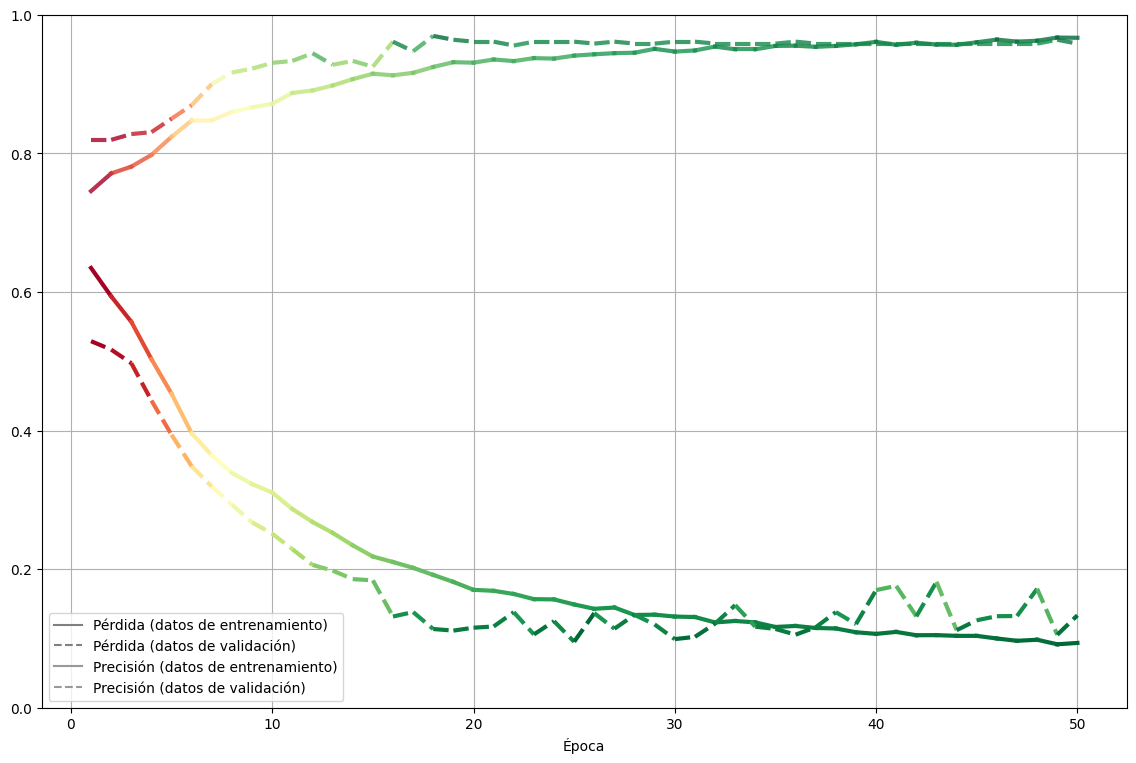

In [ ]:
historial_df = pd.DataFrame(historial.history)

plt.figure(figsize=(14, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)

#Define color maps
loss_cmap = plt.cm.get_cmap('RdYlGn_r')  # From red to green for losses
acc_cmap = plt.cm.get_cmap('RdYlGn')  # From red to green for accuracy

#Define line width
line_width = 3.0

# Trazar las series de datos y asignar las etiquetas de la leyenda
lines = [color_gradient_plot(historial_df['loss'], 'Pérdida (datos de entrenamiento)', loss_cmap, linewidth=line_width),
         color_gradient_plot(historial_df['val_loss'], 'Pérdida (datos de validación)', loss_cmap, '--', linewidth=line_width),
         color_gradient_plot(historial_df['accuracy'], 'Precisión (datos de entrenamiento)', acc_cmap, alpha=0.8, linewidth=line_width),
         color_gradient_plot(historial_df['val_accuracy'], 'Precisión (datos de validación)', acc_cmap, '--', 0.8, linewidth=line_width)]

plt.xlabel("Época")

# Mostrar la leyenda
leg = plt.legend(handles=lines, loc='best')

plt.show()

**Matriz de confusión**

Con respecto al conjunto de prueba:

10/10 [==============================] - 0s 10ms/step


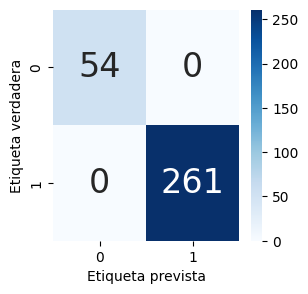

In [ ]:
#Predecir las clases para el conjunto de prueba
y_pred = model.predict(images_test)
y_pred_classes = np.argmax(y_pred, axis=1)                                      #Elige la clase con la probabilidad más alta

#Calcular la matriz de confusión
cm = confusion_matrix(labels_test, y_pred_classes)

#Mostrar la matriz de confusión
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 24})
plt.xlabel('Etiqueta prevista')
plt.ylabel('Etiqueta verdadera')
plt.show()


**Guardar el modelo** (opcional)

In [ ]:
model.save('/content/drive/MyDrive/Modelos/modelo_cancer_pulmon.h5')

#Para cargar el modelo, utlizamos la siguiente linea de codigo: model = keras.models.load_model('/content/drive/MyDrive/Modelos/modelo_cancer_pulmon.h5')

**Prediccion del modelo**

1/1 [==============================] - 0s 18ms/step


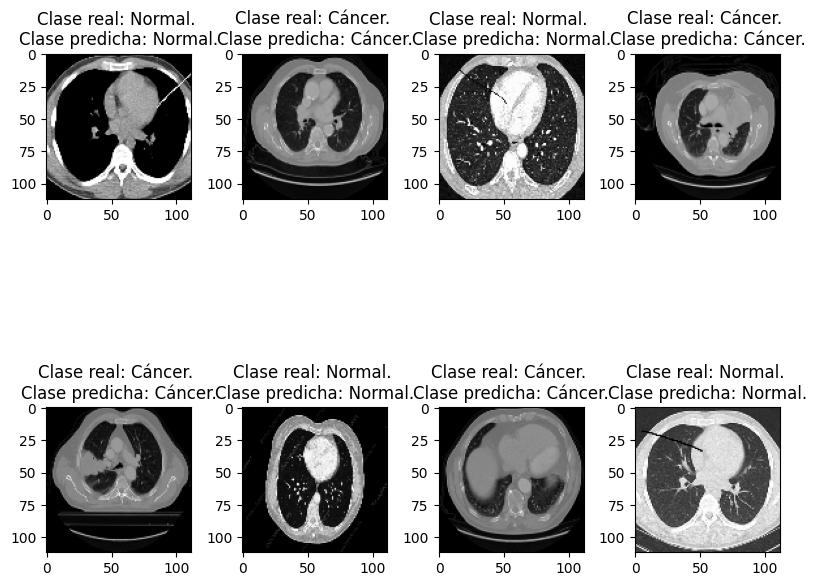

In [ ]:
num_images = 8
fig = plt.figure(figsize=(8, 8))

for i in range(num_images):
    #Imagen aleatoria de los datos de prueba
    index = random.randint(0, len(images_test) - 1)
    img = images_test[index]

    #Prediccion del modelo
    prediccion = model.predict(img[np.newaxis, ...])

    #Clase predicha
    clase_predicha = np.argmax(prediccion)

    #Muestra la imagen junto con la clase real y la predicha
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Clase real: {class_names[labels_test[index]]}. \nClase predicha: {class_names[clase_predicha]}.")

plt.tight_layout()
plt.show()
